## Churchland Widefield Data

Neural data is stored in `neural.mat`. Relevant variables are:
- `neural`: calcium traces, trials x time x component
- `reg_indxs`: NMF component regions
- `reg_indxs_consolidated`: coarse-grained regions
- `reg_indxs_consolidated`: coarse-grained regions
- `bin_times`: bin times

The widefield loading matrix for the traces in `neural.mat` is stored in `neural_nmfsupp.mat`. This should help visualize which region in the brain the activity comes from

The raw behavioral video files are in `face` and `body`, which are the two different camera views. The image files here are named as the first 4 numbers are 'trial number' and the last 4 'frame number' (189 frames per trial). I'll pull together the behavioral continuous latents and discrete segmentation etc when I get a chance. The trial markers for mSM30/10-Oct are in the file 'trialmarkers.mat'

In [1]:
import numpy as np
import ssm
import seaborn as sns
import numpy.random as npr
import matplotlib.pyplot as plt
import numpy.linalg as la
from collections import OrderedDict
from matplotlib.font_manager import FontProperties
from matplotlib.gridspec import GridSpec
from scipy.io import loadmat
from sklearn.decomposition import PCA
from ssm import LDS 
from Session import *

sns.set_style("white")
sns.set_context("talk")

In [2]:
color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]
colors = sns.xkcd_palette(color_names)

# Testing the quiescent activity segmentation

In [3]:
testsession = Session("vistrained", "mSM30", "10-Oct-2017")

In [4]:
quiescent_indices, quiescent_activity = testsession.get_quiescent_activity()

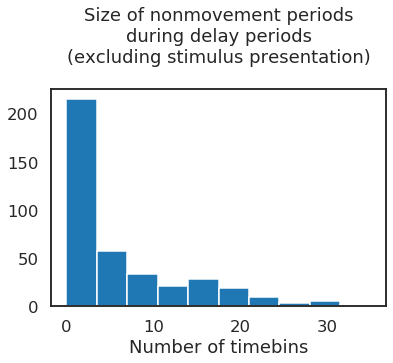

In [5]:
# Size of quiescent periods, excluding stimulus presentation
binsizes_delay_nostim = [q.shape[0] for q in quiescent_activity]
plt.figure()
plt.hist(binsizes_delay_nostim)
plt.title("Size of nonmovement periods\nduring delay periods\n(excluding stimulus presentation)\n")
plt.xlabel("Number of timebins")
plt.show()

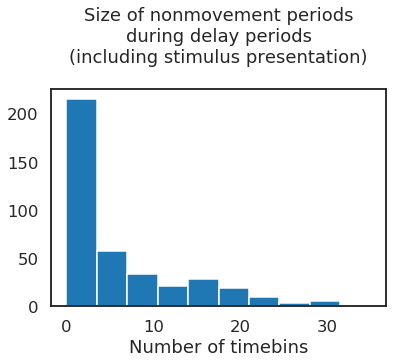

In [6]:
# Size of quiescent periods, including stimulus presentation
binsizes_delay_nostim = [q.shape[0] for q in quiescent_activity]
plt.figure()
plt.hist(binsizes_delay_nostim)
plt.title("Size of nonmovement periods\nduring delay periods\n(including stimulus presentation)\n")
plt.xlabel("Number of timebins")
plt.show(

)

## Finding a non-movement heuristic
Here, we use the $k=4$ BehaveNet discrete states as a ground truth
for finding a good heuristic over the continuous latents

In [7]:
testsession = Session("vistrained", "mSM30", "10-Oct-2017")

# The continuous behavioral latents are (trials x bin x latent_dim)
behave_latents = testsession.behavenet_latents

# The states are (trials x bin)
statefile = "/home/chingf/Code/Widefield/data/musall-analysis/" +\
    "vistrained/mSM30/10-Oct-2017/arhmm/16_latents/04_states/" +\
    "0e+00_kappa/gaussian/test_tube_data/diff_init_grid_search/" +\
    "version_0/states.pkl"
with open(statefile, "rb") as pkl:
    pkl_data = pickle.load(pkl)
states = np.array(pkl_data['states'])

In [8]:
def get_change_in_latents(behave_latents, trial, bin_t):
    """
    For a continuous behavioral latent matrix M with dimensions (trials x bin x latent_dim),
    returns M[trial,bin_t + 1, :] - M[trial,bin_t, :]
    """
    
    return behave_latents[trial, bin_t + 1, :] - behave_latents[trial, bin_t, :]

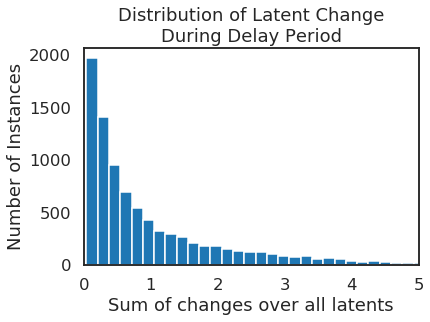

In [11]:
# Plot histogram of the difference between two time steps.
latent_vals = []
bl_dims = behave_latents.shape
for i in range(bl_dims[0]): # trial
    delay_period = testsession._get_delay_period_trial(i)
    start_bin = delay_period[0]
    end_bin = delay_period[1]
    for j in range(start_bin, end_bin): # bin number
        val = np.sum(np.abs(get_change_in_latents(behave_latents, i, j)))
        if np.isnan(val):
            continue
        else:
            latent_vals.append(val)
plt.figure()
plt.hist(latent_vals, bins=200)
plt.xlim((0,5))
plt.title("Distribution of Latent Change\nDuring Delay Period")
plt.xlabel("Sum of changes over all latents")
plt.ylabel("Number of Instances")
plt.show()

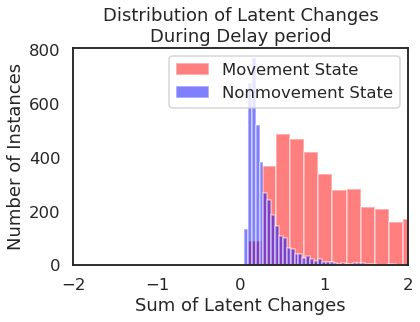

In [12]:
# Comparing the sum of behavioral latent deltas
nonmovement_state = []
movement_state = []
for trial in range(testsession.num_trials):
    delay_period = testsession._get_delay_period_trial(trial)
    start_bin = delay_period[0]
    end_bin = delay_period[1]
    b_l = behave_latents[trial,start_bin:end_bin,:]
    s = states[trial, start_bin:end_bin]
    for timebin in range(s.size):
        timebin_idx = timebin + start_bin
        latent_energy_change = np.sum(
            np.abs(get_change_in_latents(behave_latents, trial, timebin_idx))
            )
        bin_state = s[timebin]
        if np.isnan(bin_state):
            continue
        if bin_state == 1: # Non-movement
            nonmovement_state.append(latent_energy_change)
        else:
            movement_state.append(latent_energy_change)
movement_state = np.array(movement_state)
nonmovement_state = np.array(nonmovement_state)
plt.figure()
plt.hist(movement_state, color="r", alpha=0.5, bins=200,label="Movement State")
plt.hist(nonmovement_state, color="b", alpha=0.5, bins=200, label="Nonmovement State")
plt.xlim((-2,2))
plt.legend()
plt.title("Distribution of Latent Changes\nDuring Delay period")
plt.xlabel("Sum of Latent Changes")
plt.ylabel("Number of Instances")
plt.show()

In [17]:
np.sum(np.abs(movement_state) < 0.4)/movement_state.size

0.07414484999044525

In [18]:
np.sum(np.abs(nonmovement_state) < 0.4)/nonmovement_state.size

0.7771159096550012

## PCA of Trial-Averaged Responses

In [ ]:
trial_avgd_neural = np.mean(neural, axis=0) # time x component

In [ ]:
pca = PCA()
pca.fit(trial_avgd_neural.T)
print("Variance explained by first 4 principal components:")
print(pca.explained_variance_ratio_[:4])

In [ ]:
colors = ['r', 'b', 'g', 'k']
for i in range(len(colors)):
    plt.plot(
        np.squeeze(bin_times), pca.components_[i,:],
        label=str(i+1), color=colors[i]
        )
plt.legend()

## Fit a Linear Dynamical System

### Q: How to do this across sessions/trials?

In [ ]:
def fit_lds(y, observed_dim=num_components, latent_dim=10, var_post="mf"):
    """
    Fits a LDS per the SSM package. Returns:
    q: estimate of the posterior
    q_elbos: the successive elbo estimations
    q_x: the posterior mean of the continuous states
    q_y: Smoothed data under variational posterior
    """
    
    lds = LDS(observed_dim, latent_dim, emissions="gaussian")
    lds.initialize(y) # time x components, done for each trial
    q_elbos, q = lds.fit(
        y, method="bbvi", variational_posterior=var_post,
        num_iters=5000, stepsize=0.1, initialize=False
        )
    q_x = q.mean[0] # posterior mean of the continuous states
    q_y = lds.smooth(q_x, y) #Smoothed data under variational posterior
    return q, q_elbos, q_x, q_y

In [ ]:
def plot_elbos(q_elbos):
    plt.figure()
    plt.plot(q_elbos)
    plt.xlabel("Iteration")
    plt.ylabel("ELBO")

def plot_posterior_mean(q_x):
    plt.figure()
    plt.plot(q_x)
    plt.ylabel("$x$")

def plot_smoothed_observations(q_y):
    plt.figure()
    plt.plot(q_y)
    plt.xlabel("time")

In [ ]:
q, q_elbos, q_x, q_y = fit_lds(neural[0,:,:])

In [ ]:
plot_elbos(q_elbos)

In [ ]:
plot_smoothed_observations(q_y)

In [ ]:
plt.figure()
plt.plot(neural[0,:])
plt.show()

In [ ]:
plot_posterior_mean(q_x)

## Fit a RSLDS

In [ ]:
def fit_rslds(y, K=5, observed_dim=num_components, latent_dim=10, var_post="mf"):
    """
    Fits a RSLDS per the SSM package. Returns:
    q: estimate of the posterior
    q_elbos: the successive elbo estimations
    q_x: the posterior mean of the continuous states
    q_z: the most likely discrete states
    """
    
    rslds = ssm.SLDS(observed_dim, K, latent_dim,
        transitions="recurrent_only", dynamics="diagonal_gaussian",
        emissions="gaussian_orthog", single_subspace=True
        )
    rslds.initialize(y)
    q_elbos, q = rslds.fit(
        y, method="bbvi", variational_posterior="tridiag",
        initialize=False, num_iters=3000
        )
    q_x = q.mean[0]
    q_z = rslds.most_likely_states(q_x, y)
    return q, q_elbos, q_x, q_z

In [ ]:
def plot_trajectory(z, x, ax=None, ls="-"):
    cmap = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    labels = np.unique(q_z)
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=cmap[z[start] % len(cmap)],
                alpha=1.0, label=str(z[start]))
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    font_prop = FontProperties()
    font_prop.set_size('small')
    plt.legend(by_label.values(), by_label.keys(), prop=font_prop)
    return ax

In [ ]:
q, q_elbos, q_x, q_z = fit_rslds(neural[0,:,:])

In [ ]:
plt.figure()
plt.plot(q_elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO")